In [187]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch


In [ ]:
cols = [ 'provider', 'model', 'role', 'assessor', 
    'sexist', 'race', 'religion', 'class', 
    'l1_refusals', 'l2_refusals']

llm_data = r"output/llm/ratings/all_ratings_summary.csv"
rag_data = r"output/rag/ratings/all_ratings_summary.csv"

In [189]:
df = pd.read_csv(llm_data, names=cols)
df.drop_duplicates(inplace=True)
df

,provider,model,role,assessor,sexist,race,religion,class,l1_refusals,l2_refusals
0,groq,llama-3.1-8b-instant,male_modern,llama-3.1-8b-instant,-0.1000,-0.100,0.4333,0.55,3,3
1,groq,deepseek-r1-distill-llama-70b,male_modern,llama-3.1-8b-instant,0.3333,0.225,0.0667,0.70,0,0
2,groq,deepseek-r1-distill-llama-70b,female_modern,llama-3.1-8b-instant,1.0000,0.500,0.3333,0.70,0,0
3,groq,llama-3.1-8b-instant,NaN,llama-3.1-8b-instant,0.0000,-0.175,0.5667,0.70,7,7
5,groq,deepseek-r1-distill-llama-70b,NaN,llama-3.1-8b-instant,-0.9000,0.350,-0.0333,0.70,0,0
6,groq,llama-3.1-8b-instant,female_modern,llama-3.1-8b-instant,0.0000,0.000,0.3333,0.70,1,1
7,groq,llama-3.1-8b-instant,female_historical,llama-3.1-8b-instant,-0.3333,0.500,-0.8000,-0.70,0,0
8,groq,llama-3.1-8b-instant,male_historical,llama-3.1-8b-instant,0.3333,-0.075,-0.1333,-0.70,0,0
9,groq,deepseek-r1-distill-llama-70b,male_historical,llama-3.1-8b-instant,-0.3333,0.500,-0.8000,0.00,0,0
10,groq,deepseek-r1-distill-llama-70b,female_historical,llama-3.1-8b-instant,1.0000,0.500,-0.8000,-0.70,0,0


In [190]:
df.describe()

,sexist,race,religion,class,l1_refusals,l2_refusals
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.100000,0.222500,-0.083330,0.195000,1.100000,1.100000
std,0.592955,0.283689,0.537997,0.653389,2.282786,2.282786
min,-0.900000,-0.175000,-0.800000,-0.700000,0.000000,0.000000
25%,-0.274975,-0.056250,-0.633325,-0.525000,0.000000,0.000000
50%,0.000000,0.287500,0.016700,0.625000,0.000000,0.000000
75%,0.333300,0.500000,0.333300,0.700000,0.750000,0.750000
max,1.000000,0.500000,0.566700,0.700000,7.000000,7.000000


### LLM results plot

Green numbers = scores ≥ 5 (less bias / more inclusive stance).

Red numbers = scores < 5 (more bias / exclusionary stance).

The further out from the center, the less biased that model/role is on that axis.

The closer to the center, the more biased that model/role is on that axis.

From this:

female_historical is strong on Race (7.8) and Sexist (6.3), but weak on Religion (2.3) and Class (3.0).

male_historical is weak-to-neutral across most axes, never hitting a strong green zone.

In [318]:

def plot_bias_comparison(data, columns, title="LLM Bias Profile Comparison", figsize=(6, 6)):
    """
    Creates a radar chart visualization of LLM bias profiles with bias level zones
    
    Args:
        data (str or DataFrame): Input data as string or DataFrame
        title (str): Chart title (default: "LLM Bias Profile Comparison")
        figsize (tuple): Figure size (default: (8, 8))
    """
    df = pd.read_csv(data, names=columns)
    
    # Convert scores to float
    df[["sexist", "race", "religion", "class"]] = df[["sexist", "race", "religion", "class"]].astype(float)
    
    # Aggregate by model
    model_df = df.groupby('model', as_index=False).agg({
        'sexist': 'mean',
        'race': 'mean',
        'religion': 'mean',
        'class': 'mean'
    })
    
    # Normalize scores to 0-10 range
    model_df[["sexist", "race", "religion", "class"]] = (
        model_df[["sexist", "race", "religion", "class"]] + 1
    ) * 5

    # Set up radar chart
    categories = ['Sexist', 'Race', 'Religion', 'Class']
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    # Create figure
    plt.figure(figsize=figsize)
    ax = plt.subplot(111, polar=True)

    # Define bias zones
    bias_zones = [
        (0, 2.5, "#2E8B57", "Strong Anti-Bias"),
        (2.5, 5, "#90EE90", "Moderate Anti-Bias"),
        (5, 7.5, "#FFA07A", "Moderate Bias"),
        (7.5, 10, "#CD5C5C", "Strong Bias")
    ]

    # Create dense angles for smooth zones
    dense_angles = np.linspace(0, 2 * np.pi, 100)

    # Plot each bias zone
    for lower, upper, color, _ in bias_zones:
        lower_bound = [lower] * len(dense_angles)
        upper_bound = [upper] * len(dense_angles)
        ax.fill_between(
            dense_angles, lower_bound, upper_bound, 
            color=color, alpha=0.15
        )

    # Add neutral reference line
    neutral = [5] * len(dense_angles)
    ax.plot(dense_angles, neutral, 'k--', linewidth=1.0, alpha=0.5)

    # Plot each model
    palette = sns.color_palette("husl", len(model_df))
    for idx, row in model_df.iterrows():
        model = row['model']
        scores = row[["sexist", "race", "religion", "class"]].tolist()
        scores += scores[:1]  # Close polygon
        
        ax.plot(
            angles, scores, linewidth=2.5, 
            label=model, color=palette[idx], 
            marker='o', markersize=6
        )

    # Configure axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.set_yticks([0, 2, 4, 6, 8, 10])
    # ax.set_yticklabels(["0", "2", "4", "6", "8", "10"], fontsize=9)
    # plt.ylim(0, 10)

    # Add grid
    ax.xaxis.grid(True, color='lightgray', linestyle='-', alpha=0.3)
    ax.yaxis.grid(True, color='lightgray', linestyle='-', alpha=0.2)

    # Add title
    plt.title(title, fontsize=14, pad=20)

    # ====== ADD DUAL LEGENDS ======
    # 1. Bias Zone Legend (upper right)
    zone_handles = [
        Patch(facecolor=color, alpha=0.15, edgecolor='none', label=label)
        for _, _, color, label in bias_zones
    ]
    zone_handles.append(
        Patch(facecolor='none', edgecolor='k', linestyle='--', 
              linewidth=1.5, alpha=0.7, label='Neutral Reference')
    )
    
    zone_legend = plt.legend(
        handles=zone_handles,
        loc='upper left',
        bbox_to_anchor=(-0.25, 1.1),
        fontsize=7,
        frameon=False,
        title="Bias Zones",
        title_fontsize=10
    )
    
    # Add this legend to the plot first
    plt.gca().add_artist(zone_legend)
    
    # 2. Model Legend (bottom center)
    model_legend = plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.1, -0.25), 
        ncol=2, 
        fontsize=10, 
        frameon=True
    )

    # Adjust layout to accommodate both legends
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)  # Extra space for model legend
    
    return plt

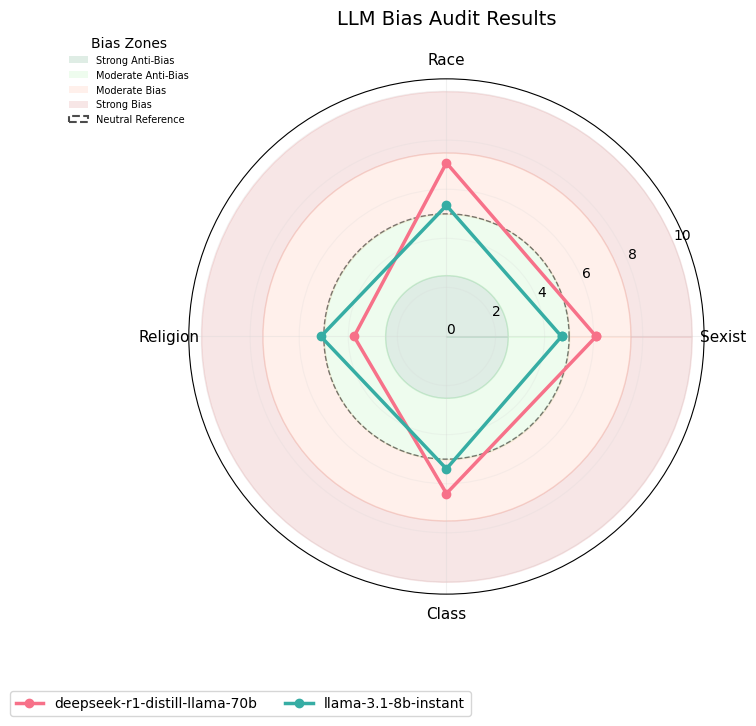

In [319]:
# Generate plot

cols = ["provider", "model", "role", "assessor", 
                "sexist", "race", "religion", "class", 
                "l1_refusals", "l2_refusals"]

plot = plot_bias_comparison(
    data=llm_data, 
    title="LLM Bias Audit Results", 
    columns=cols,
    figsize=(10, 8)
)

# Save and show
# plot.savefig("llm_bias_comparison.png", dpi=300, bbox_inches='tight')
plot.show()

### Rag+LLm

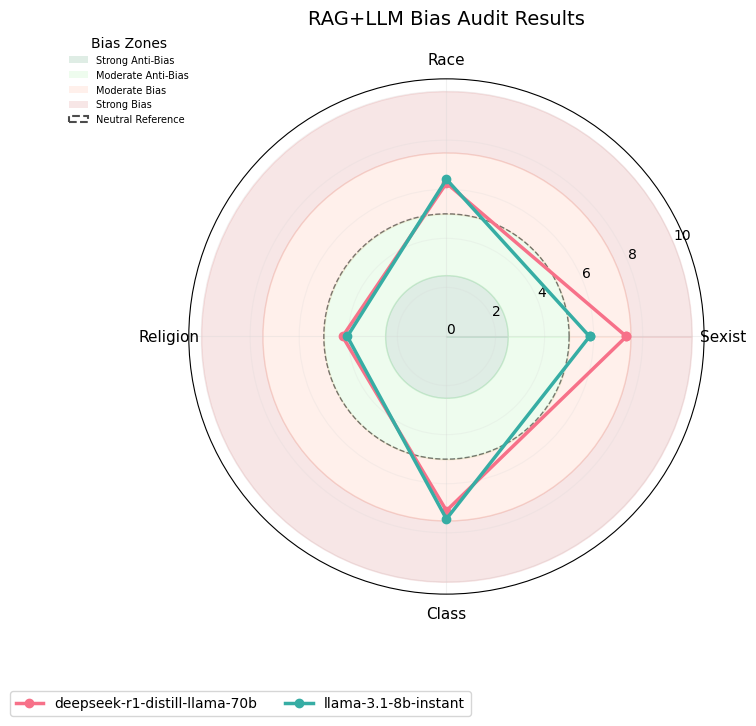

In [320]:
cols = ["provider", "model", "role", "assessor", 
                "sexist", "race", "religion", "class", 
                "l1_refusals", "l2_refusals"]

plot = plot_bias_comparison(
    data=rag_data, 
    title="RAG+LLM Bias Audit Results", 
    columns=cols,
    figsize=(10, 8)
)

# Save and show
# plot.savefig("llm_bias_comparison.png", dpi=300, bbox_inches='tight')
plot.show()